# Филтриране на данните

In [1]:
import os
import numpy as np 
import pandas as pd

import seaborn as sns
sns.set(style="darkgrid")

from config import bboxes_file, train_image_dir

import matplotlib.pyplot as plt
# Needed to fix the issue that pd.DataFrame.hist() doesn't show anything the first time it's executed
plt.close('all')

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Зареждане на данните

In [2]:
images_df = pd.read_csv(bboxes_file, header=None, names=['image_id', 'x1', 'y1', 'x2', 'y2', 'class'], index_col='image_id')

# Convert float columns to int, so they can be used to draw the bounding boxes without casting
for col in ['x1', 'y1', 'x2', 'y2']:
    images_df[col] = images_df[col].fillna(-1)
    images_df[col] = images_df[col].astype('Int32')
    images_df[col] = images_df[col].replace(-1, np.nan)

## Разглеждане на данните

In [3]:
print("Dataset shape: ", images_df.shape)
images_df.head()

Dataset shape:  (223591, 5)


,x1,y1,x2,y2,class
image_id,,,,,
00003e153.jpg,NaN,NaN,NaN,NaN,NaN
0001124c7.jpg,NaN,NaN,NaN,NaN,NaN
000155de5.jpg,344,465,448,501,ship
000194a2d.jpg,67,377,85,387,ship
000194a2d.jpg,258,174,306,185,ship


In [4]:
images_df.loc[images_df['class'] == 'ship', 'ships'] = 1

unique_images_df = images_df.groupby(images_df.index).agg({'ships': 'sum'}).reset_index()
unique_images_df['has_ship'] = unique_images_df['ships'].map(lambda x: 1.0 if x>0 else 0.0)

# We don't need the 'ships' column in the main dataframe anymore
images_df = images_df.drop(['ships'], axis=1)

Да разгледаме разпределението по брой кораби

In [5]:
unique_images_df[unique_images_df['ships'] >= 0]['ships'].value_counts()

0.0     150000
1.0      28775
2.0       7290
3.0       2787
4.0       1404
5.0        754
6.0        473
7.0        348
8.0        228
9.0        161
10.0       118
11.0        76
12.0        62
13.0        36
15.0        23
14.0        15
28.0         2
31.0         2
17.0         1
24.0         1
Name: ships, dtype: int64

Да видим визуално разпределението на картинките, като премахнем тези без кораби, тъй като те само ще 

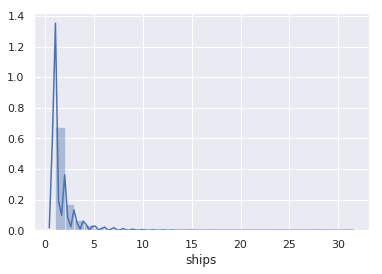

In [6]:
sns.distplot(unique_images_df[unique_images_df['ships'] > 0]['ships'], bins=30);

Нека разгледаме големините на файловете

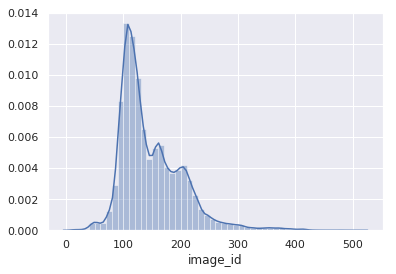

In [7]:
sns.distplot(unique_images_df['image_id'].map(
    lambda c_img_id: 
        os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024
));

В baseline kernel-а в Кагъл се филтрират картинките, които са по-малки от 50кб, но разгледах някои от тях и изглеждаха валидни картинки. Размерът им е по-малък, защото в тях преобладава един цвят (син). Затова реших да ги оставя.

## Изводи

1) Имаме огромен дейтасет и за да можем да направим няколко експериментa, ще трябва да го намалим

2) Иглежда на 3/4 от картинките няма нито един кораб. Ако оставим данните със същата пропорция по-скоро ще забавим тренирането на модела, отколкото ще повишим точността. 

## Намаляване не dataset-а

In [8]:
unique_images_df.shape

(192556, 3)

In [9]:
unique_images_df['grouped_ship_count'] = unique_images_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=5000):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3, random_state=42) # even more strongly undersample no ships
    else:
        return in_df.sample(min(base_rep_val, in_df.shape[0]), random_state=42)
    
balanced_unique_images_df = unique_images_df.groupby('grouped_ship_count') \
    .apply(sample_ships) \
    .set_index('image_id') \
    .drop(['grouped_ship_count'], axis=1)

unique_images_df = unique_images_df.drop(['grouped_ship_count'], axis=1)


Да разгледаме получените данни, за да видим дали са добре балансирани

In [10]:
print('Shape: ', balanced_unique_images_df.shape)
balanced_unique_images_df.describe()

Shape:  (13157, 2)


,ships,has_ship
count,13157.000000,13157.000000
mean,2.752603,0.873375
std,2.539438,0.332565
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,4.000000,1.000000
max,31.000000,1.000000


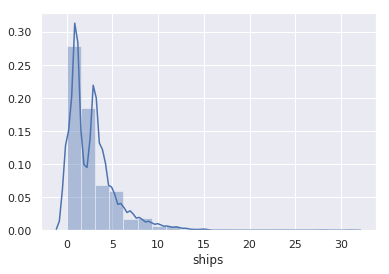

In [11]:
sns.distplot(balanced_unique_images_df['ships'], bins=20);

In [12]:
balanced_unique_images_df['ships'].value_counts()

1.0     4020
3.0     2787
0.0     1666
4.0     1404
2.0      980
5.0      754
6.0      473
7.0      348
8.0      228
9.0      161
10.0     118
11.0      76
12.0      62
13.0      36
15.0      23
14.0      15
28.0       2
31.0       2
24.0       1
17.0       1
Name: ships, dtype: int64

Ако пуснем train_test_split със stratify='ships' ще получим грешка, тъй като има класове, за които имаме само по един пример (ships=17, ships=24, ...). Затова ще обединим в един клас (ships=14) всички картинки, които имат >= 14 кораба

In [13]:
balanced_unique_images_df['ships'] = balanced_unique_images_df['ships'].clip(0, 14)

In [14]:
def train_test_split_df(in_df, test_size):
    train_ids, test_ids = train_test_split(
        in_df, 
        test_size = test_size, 
        stratify = in_df['ships'],
        random_state=42)


    train_df = pd.merge(images_df, train_ids, left_index=True, right_index=True).drop(['ships', 'has_ship'], axis=1)
    test_df = pd.merge(images_df, test_ids, left_index=True, right_index=True).drop(['ships', 'has_ship'], axis=1)

    return train_df, test_df, train_ids
    
train_validation_df, test_df, train_validation_ids = train_test_split_df(balanced_unique_images_df, test_size=0.2)
train_df, validation_df, _ = train_test_split_df(train_validation_ids, test_size=0.25)

print(train_df.shape[0], 'training examples')
print(validation_df.shape[0], 'validation examples')
print(test_df.shape[0], 'test examples')

22715 training examples
7587 validation examples
7580 test examples


Имаме доста повече примери отколкото картинки, защото много от картинките имат по повече от един анотиран кораб

Ще запазим генерираните train, validation и test данни, за да можем да ги подадем на keras_retinanet модела

In [15]:
def save_bboxes_to_file(bboxes_df, filename):
    bboxes_df.to_csv(filename, header=False)

In [16]:
save_bboxes_to_file(train_df, os.path.join(train_image_dir, 'train.csv'))
save_bboxes_to_file(validation_df, os.path.join(train_image_dir, 'validation.csv'))
save_bboxes_to_file(test_df, os.path.join(train_image_dir, 'test.csv'))